In [1]:
import os
import sys
sys.path.append('/nfs/h1/userhome/ChenXiaYu/workingdir/code/MagicBox')
import numpy as np
import pandas as pd
import pickle as pkl
import nibabel as nib
from os.path import join as pjoin
from scipy.stats.stats import sem, pearsonr, spearmanr
from scipy.spatial.distance import pdist
from functools import partial
from matplotlib import pyplot as plt
from magicbox.io.io import CiftiReader
from magicbox.stats.metric import calc_coef_var
from magicbox.algorithm.plot import plot_polyfit
from cxy_visual_dev.lib.predefine import proj_dir, Atlas,\
    LR_count_32k, s1200_avg_eccentricity, mmp_map_file,\
    get_rois, s1200_avg_myelin, s1200_avg_thickness,\
    s1200_avg_RFsize, s1200_avg_R2

anal_dir = pjoin(proj_dir, 'analysis')
work_dir = pjoin(anal_dir, 'plot/scatter')
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)

# 结构PC1/2与其它指标在ROI级别上的相关

## ROI scalar

### stru-C1/2与查阅文献得到的脑区层级的关系


---mean_stru-C1---
polynomial:
  
10.96 x - 57.98

score: (0.9757679998030326, 3.034096149179312e-07)
spearmanr: SpearmanrResult(correlation=0.990909090909091, pvalue=3.762571807085399e-09)
pearsonr: (0.9757679998030326, 3.034096149179312e-07)

---mean_stru-C2---
polynomial:
  
1.264 x + 1.465

score: (0.38154597914713806, 0.24692482078160652)
spearmanr: SpearmanrResult(correlation=0.4272727272727273, pvalue=0.189943724965427)
pearsonr: (0.38154597914713806, 0.24692482078160652)


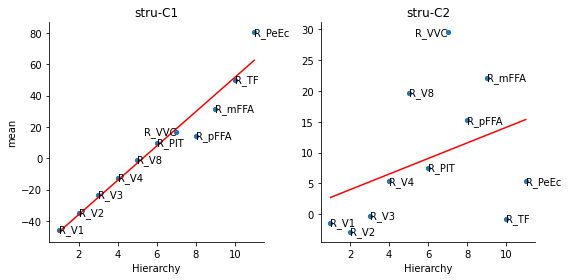

In [2]:
path_name = 'Hierarchy5'
figsize = (8, 4)
pc_names = ['stru-C1', 'stru-C2']
metrics = ['mean']
rois = [f'R_{i}' for i in get_rois(path_name)]
fpath = pjoin(anal_dir, 'ROI_scalar/ROI_scalar1_MMP-vis3-R.csv')
out_file = pjoin(work_dir, f'PC12-corr-{path_name}.jpg')
# out_file = 'show'

n_pc = len(pc_names)
n_metric = len(metrics)
df = pd.read_csv(fpath, index_col=0)

if path_name == 'Hierarchy4':
    roi2label = {
        'R_FFA1': 'R_pFus-faces',
        'R_FFA2': 'R_mFus-faces'}
    label2key = {
        'R_pFus-faces': 1,
        'R_mFus-faces': 2}
    pc_maps = nib.load(pjoin(
        anal_dir, 'decomposition/HCPY-M+corrT_MMP-vis3-R_zscore1_PCA-subj.dscalar.nii'
    )).get_fdata()[:2]
    split_map = nib.load(pjoin(
        proj_dir, 'data/HCP-YA_FFA-split.32k_fs_LR.dlabel.nii'
    )).get_fdata()[0]
    for roi, lbl in roi2label.items():
        mask = split_map == label2key[lbl]
        for pc_idx, pc_name in enumerate(pc_names):
            idx = f'mean_{pc_name}'
            df.loc[idx, roi] = np.mean(pc_maps[pc_idx][mask])
elif path_name == 'Hierarchy5':
    roi2label = {
        'R_pFFA': 'R_pFus-faces',
        'R_mFFA': 'R_mFus-faces'}
    label2key = {
        'R_pFus-faces': 1,
        'R_mFus-faces': 2}
    pc_maps = nib.load(pjoin(
        anal_dir, 'decomposition/HCPY-M+corrT_MMP-vis3-R_zscore1_PCA-subj.dscalar.nii'
    )).get_fdata()[:2]
    mpm_map = nib.load(pjoin(
        proj_dir, 'data/HCP-YA_FFA-MPM_thr-25.32k_fs_LR.dlabel.nii'
    )).get_fdata()[0]
    for roi, lbl in roi2label.items():
        mask = mpm_map == label2key[lbl]
        for pc_idx, pc_name in enumerate(pc_names):
            idx = f'mean_{pc_name}'
            # MPM会有部分超出当前定义的视觉皮层
            df.loc[idx, roi] = np.nanmean(pc_maps[pc_idx][mask])

fig, axes = plt.subplots(n_metric, n_pc, figsize=figsize)
x = np.arange(1, len(rois)+1)
xlabel = 'Hierarchy'
for pc_idx, pc_name in enumerate(pc_names):
    for metric_idx, metric in enumerate(metrics):
        # ax = axes[pc_idx, metric_idx]
        ax = axes[pc_idx]
        idx = f'{metric}_{pc_name}'
        y = df.loc[idx, rois].values
        print(f'\n---{idx}---')
        plot_polyfit(x, y, 1, color='r', s=18, ax=ax)
        print('spearmanr:', spearmanr(x, y))
        print('pearsonr:', pearsonr(x, y))
        if metric_idx == (n_metric - 1):
            ax.set_xlabel(xlabel)
        if pc_idx == 0:
            ax.set_ylabel(metric)
        if metric_idx == 0:
            ax.set_title(pc_name)
        for j, i, roi in zip(x, y, rois):
            if roi == 'R_VVC':
                ha, va = 'right', 'center'
            else:
                ha, va = 'left', 'center'
            ax.text(j, i, roi, horizontalalignment=ha, verticalalignment=va)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

### 以RFsize的均值为x轴（作为功能层级的代表），PC1/2为y轴。PC1/2可以是均值，标准差，变异系数。

#ROI: 23
ROIs: ['R_V1v', 'R_V1d', 'R_V2v', 'R_V2d', 'R_V3v', 'R_V3d', 'R_hV4', 'R_VO1', 'R_VO2', 'R_PHC1', 'R_PHC2', 'R_TO2', 'R_TO1', 'R_LO2', 'R_LO1', 'R_V3B', 'R_V3A', 'R_IPS0', 'R_IPS1', 'R_IPS2', 'R_IPS3', 'R_IPS4', 'R_SPL1']

---mean_PC1---
polynomial:
  
6.694 x - 30.17

score: (0.7129357597181747, 0.00013455406679688332)
spearmanr: SpearmanrResult(correlation=0.7075098814229249, pvalue=0.00015945953759802014)
pearsonr: (0.7129357597181745, 0.00013455406679688427)

---std_PC1---
polynomial:
  
0.189 x + 5.671

score: (0.12836926702678686, 0.5594025674637517)
spearmanr: SpearmanrResult(correlation=0.13932806324110672, pvalue=0.5260576523058189)
pearsonr: (0.12836926702678675, 0.5594025674637516)

---cv_PC1---
polynomial:
  
0.1145 x + 0.3132

score: (0.46902668899434474, 0.02396491512416963)
spearmanr: SpearmanrResult(correlation=0.5602766798418972, pvalue=0.0054265944192421365)
pearsonr: (0.46902668899434474, 0.02396491512416963)

---mean_PC2---
polynomial:
  
1.519 x - 3.916

s

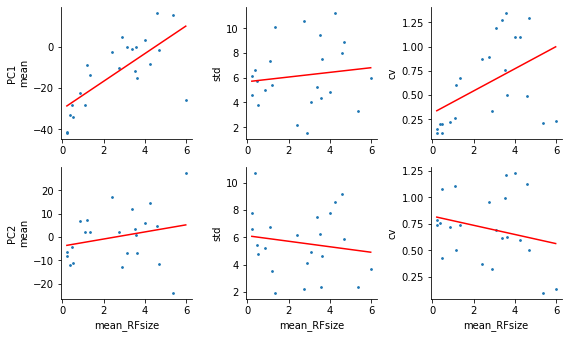

In [5]:
Hemi = 'R'

# rois = 'all'
# R2_limit = False
# fpath = pjoin(anal_dir, f'ROI_scalar/ROI_scalar1_MMP-vis3-{Hemi}.csv')

rois = get_rois(f'Wang2015-{Hemi}')
if Hemi == 'L':
    # L_FEF与MMP-vis3-L没有重合的部分，前者在额叶.
    # L_IPS5有10个顶点，与MMP-vis3-L重合的有8个
    # L_TO2只有2个顶点，但都与MMP-vis3-L重合
    rois.remove(f'{Hemi}_FEF')
elif Hemi == 'R':
    # R_FEF和R_IPS5与MMP-vis3-R没有重合的部分，前者在额叶，后者本身只有3个顶点。
    rois.remove(f'{Hemi}_FEF')
    rois.remove(f'{Hemi}_IPS5')
else:
    raise ValueError
R2_limit = False  # 只能是False
fpath = pjoin(anal_dir, f'ROI_scalar/ROI_scalar1_Wang2015-{Hemi}.csv')

figsize = (8, 4.8)
xlabel = 'mean_RFsize'
pc_names = ['PC1', 'PC2']
metrics = ['mean', 'std', 'cv']
out_file = pjoin(work_dir, f'ROI_scalar1_{Hemi}.jpg')
# out_file = 'show'

n_pc = len(pc_names)
n_metric = len(metrics)
df = pd.read_csv(fpath, index_col=0)
if rois == 'all':
    rois = df.columns

if R2_limit:
    # 只保留跨顶点的平均R2大于9.8的脑区
    atlas = Atlas('HCP-MMP')
    R2_map = nib.load(s1200_avg_R2).get_fdata()[0, :LR_count_32k]
    rois_tmp = []
    for roi in rois:
        mask = atlas.get_mask(roi)[0]
        if np.mean(R2_map[mask]) > 9.8:
            rois_tmp.append(roi)
    rois = rois_tmp
print('#ROI:', len(rois))
print('ROIs:', rois)

fig, axes = plt.subplots(n_pc, n_metric, figsize=figsize)
x = df.loc[xlabel, rois].values
for pc_idx, pc_name in enumerate(pc_names):
    for metric_idx, metric in enumerate(metrics):
        ax = axes[pc_idx, metric_idx]
        idx = f'{metric}_{pc_name}'
        y = df.loc[idx, rois].values
        print(f'\n---{idx}---')
        plot_polyfit(x, y, 1, color='r', s=3, ax=ax)
        print('spearmanr:', spearmanr(x, y))
        print('pearsonr:', pearsonr(x, y))
        if pc_idx == (n_pc - 1):
            ax.set_xlabel(xlabel)
        if metric_idx == 0:
            ax.set_ylabel(f'{pc_name}\n{metric}')
        else:
            ax.set_ylabel(metric)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

### 用(Benson et al., 2018, eLife)的retinotopic prior。以RFsize的均值为x轴（作为功能层级的代表），PC1/2为y轴。PC1/2可以是均值，标准差，变异系数。


---mean_stru-C1---
polynomial:
  
3.671 x - 26.73

score: (0.43178654034713787, 0.16101742836727156)
spearmanr: SpearmanrResult(correlation=0.3356643356643357, pvalue=0.2861229029149875)
pearsonr: (0.43178654034713776, 0.1610174283672719)

---std_stru-C1---
polynomial:
  
0.2313 x + 9.399

score: (0.11500992932847505, 0.7219003656739704)
spearmanr: SpearmanrResult(correlation=0.41958041958041964, pvalue=0.1745190081300594)
pearsonr: (0.11500992932847487, 0.7219003656739704)

---cv_stru-C1---
polynomial:
  
0.08917 x + 0.3763

score: (0.4892657078757425, 0.10645387158479067)
spearmanr: SpearmanrResult(correlation=0.39860139860139865, pvalue=0.19933549461780897)
pearsonr: (0.48926570787574236, 0.10645387158479089)

---mean_stru-C2---
polynomial:
  
2.18 x - 4.135

score: (0.5318408584005287, 0.0751197113520722)
spearmanr: SpearmanrResult(correlation=0.5734265734265735, pvalue=0.05126558978649144)
pearsonr: (0.5318408584005286, 0.07511971135207227)

---std_stru-C2---
polynomial:
  
0.385

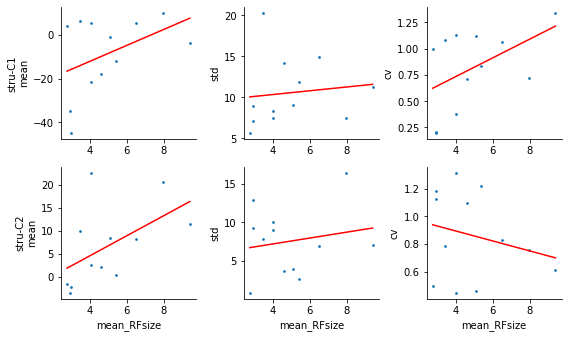

In [2]:
roi_nums = range(1, 13)
n_pc = 2
pc_names = [f'stru-C{i}' for i in range(1, n_pc + 1)]
gii_pcs = nib.load(pjoin(
    anal_dir, 'decomposition/HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_fsavg.func.gii'
))
meas_file = pjoin(proj_dir, 'data/benson2018/analyses/fsaverage/rh.anatomical-prior_sigma.mgz')
atlas_file = pjoin(proj_dir, 'data/benson2018/analyses/fsaverage/rh.anatomical-prior_varea.mgz')

atlas_map = nib.load(atlas_file).get_fdata().squeeze()
pc_maps = [gii_pcs.darrays[i].data for i in range(n_pc)]
meas_map = nib.load(meas_file).get_fdata().squeeze()

figsize = (8, 4.8)
xlabel = 'mean_RFsize'
metrics = ['mean', 'std', 'cv']
metric2func = {
    'mean': np.mean,
    'std': partial(np.std, ddof=1),
    'cv': partial(calc_coef_var, ddof=1)}
out_file = pjoin(work_dir, 'ROI_scalar1.jpg')
# out_file = 'show'

n_pc = len(pc_names)
n_metric = len(metrics)
fig, axes = plt.subplots(n_pc, n_metric, figsize=figsize)
x = [np.mean(meas_map[atlas_map == i]) for i in roi_nums]
for pc_idx, pc_name in enumerate(pc_names):
    for metric_idx, metric in enumerate(metrics):
        ax = axes[pc_idx, metric_idx]
        idx = f'{metric}_{pc_name}'
        y = []
        for roi_num in roi_nums:
            samples = pc_maps[pc_idx][atlas_map == roi_num]
            samples = samples[~np.isnan(samples)]
            y.append(metric2func[metric](samples))
        print(f'\n---{idx}---')
        plot_polyfit(x, y, 1, color='r', s=3, ax=ax)
        print('spearmanr:', spearmanr(x, y))
        print('pearsonr:', pearsonr(x, y))
        if pc_idx == (n_pc - 1):
            ax.set_xlabel(xlabel)
        if metric_idx == 0:
            ax.set_ylabel(f'{pc_name}\n{metric}')
        else:
            ax.set_ylabel(metric)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

# 梯度与行为的相关

#valid subject: 1088
polynomial:
  
0.1085 x + 16.8

score: (0.0012519791163716036, 0.967097483866723)
pearsonr (0.0012519791163664133, 0.9670974838669069)
polynomial:
  
8.615 x + 14.37

score: (0.10564570534876691, 0.00048216546422453756)
pearsonr (0.10564570534876684, 0.000482165464224565)


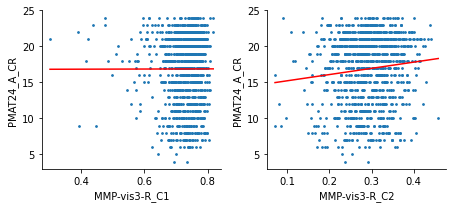

In [7]:
info_file = pjoin(proj_dir, 'data/HCP/HCPY_SubjInfo.csv')
info_df = pd.read_csv(info_file)

# ---behavior measures---
beh_name = 'PMAT24_A_CR'
beh_file1 = '/nfs/m1/hcp/S1200_behavior.csv'
beh_file2 = '/nfs/m1/hcp/S1200_behavior_restricted.csv'
beh_df1 = pd.read_csv(beh_file1)
beh_df2 = pd.read_csv(beh_file2)
assert np.all(beh_df1['Subject'] == beh_df2['Subject'])
beh_df2 = beh_df2.drop('Subject', axis=1)
beh_df = pd.concat([beh_df1, beh_df2], axis=1)
beh_vec = np.array(beh_df[beh_name])

# limited in 1096 subjects
subj_ids_beh = beh_df['Subject'].to_list()
subj_indices = [subj_ids_beh.index(i) for i in info_df['subID']]
beh_vec = beh_vec[subj_indices]
non_nan_vec = ~np.isnan(beh_vec)
print('#valid subject:', np.sum(non_nan_vec))
beh_vec = beh_vec[non_nan_vec]

# ---HCPY-M+T_fit_PC_subj-wise---
mt_fit_pc_names = ['MMP-vis3-R_C1', 'MMP-vis3-R_C2']
mt_fit_pc_file = pjoin(anal_dir, 'fit/HCPY-M+T_fit_PC_subj-wise.pkl')
mt_fit_pc_data = pkl.load(open(mt_fit_pc_file, 'rb'))

# plot
fig, axes = plt.subplots(1, 2, figsize=(6.4, 3))
for idx, name in enumerate(mt_fit_pc_names):
    ax = axes[idx]
    x = mt_fit_pc_data[name][non_nan_vec]
    plot_polyfit(x, beh_vec, 1, color='r', s=3, ax=ax)
    print('pearsonr', pearsonr(x, beh_vec))
    ax.set_xlabel(name)
    ax.set_ylabel(beh_name)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.tight_layout()
fig.savefig(pjoin(work_dir, f'gradient-corr-beh.jpg'))

# 梯度空间距离预测功能与结构连接强度

## 梯度空间距离预测功能连接强度

### vertex-level

polynomial:
  
-0.0008597 x + 0.09675

score: (0.46134192606794044, 0.0)
pearsonr (-0.46134192606794033, 0.0)
SpearmanrResult(correlation=-0.48478262853029797, pvalue=0.0)
polynomial:
  
-0.0008632 x + 0.09705

score: (0.4648671059327821, 0.0)
pearsonr (-0.464867105932782, 0.0)
SpearmanrResult(correlation=-0.488245536391455, pvalue=0.0)


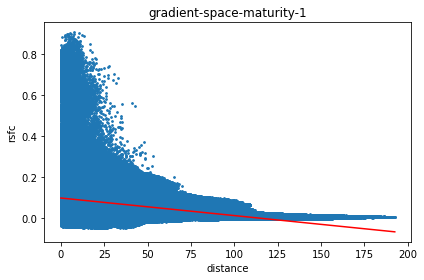

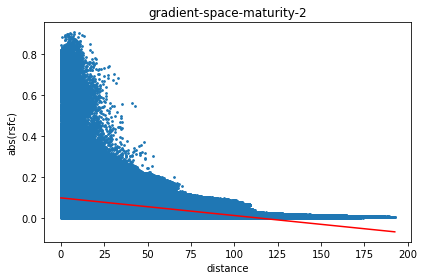

In [2]:
out_name = 'gradient-space-maturity'
rsfc_file = pjoin(proj_dir, 'data/HCP/HCPY-avg_RSFC-MMP-vis3-R2grayordinate.pkl')
rsfc_data = pkl.load(open(rsfc_file, 'rb'))
rsfc_mat = rsfc_data['matrix'][:, rsfc_data['row-idx_to_32k-fs-LR-idx']]
assert np.all(np.diag(rsfc_mat) == 1)
n_vtx = len(rsfc_data['row-idx_to_32k-fs-LR-idx'])
pc_maps = nib.load(pjoin(
        anal_dir, 'decomposition/HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj.dscalar.nii'
    )).get_fdata()[:2][:, rsfc_data['row-idx_to_32k-fs-LR-idx']]
del rsfc_data
n_item = (n_vtx * n_vtx - n_vtx) / 2
idx_mat = np.tri(n_vtx, k=-1, dtype=bool).T

x = pdist(pc_maps.T)
y1 = rsfc_mat[idx_mat]
fig1, ax1 = plt.subplots(1, 1)
plot_polyfit(x, y1, 1, color='r', s=3, ax=ax1)
ax1.set_xlabel('distance')
ax1.set_ylabel('rsfc')
ax1.set_title(f'{out_name}-1')
fig1.tight_layout()
fig1.savefig(pjoin(work_dir, f'{out_name}-1.jpg'))
print('pearsonr', pearsonr(x, y1))
print(spearmanr(x, y1))

y2 = np.abs(y1)
fig2, ax2 = plt.subplots(1, 1)
plot_polyfit(x, y2, 1, color='r', s=3, ax=ax2)
ax2.set_xlabel('distance')
ax2.set_ylabel('abs(rsfc)')
ax2.set_title(f'{out_name}-2')
fig2.tight_layout()
fig2.savefig(pjoin(work_dir, f'{out_name}-2.jpg'))
print('pearsonr', pearsonr(x, y2))
print(spearmanr(x, y2))

### roi-level

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


polynomial:
  
0.003541 x + 0.5549

score: (0.42974878901267144, 8.413386581131297e-44)
pearsonr (0.42974878901267155, 8.413386581131297e-44)
SpearmanrResult(correlation=0.4079793256139613, pvalue=3.033044210427964e-39)

---abs---
polynomial:
  
0.003541 x + 0.5549

score: (0.42974878901267144, 8.413386581131297e-44)
pearsonr (0.42974878901267155, 8.413386581131297e-44)
SpearmanrResult(correlation=0.4079793256139613, pvalue=3.033044210427964e-39)


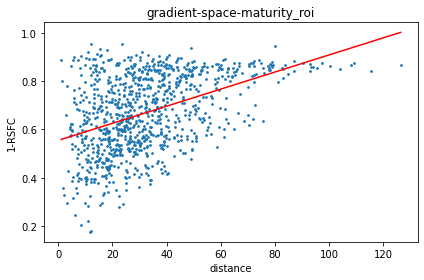

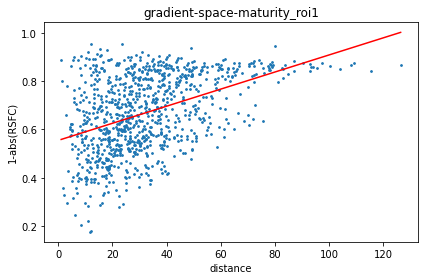

In [4]:
rsfc_type = 'corr dist'  # corr, corr dist
out_name = 'gradient-space-maturity'
# out_name = 'surface-space-control'
# out_name = 'M+T-control'
atlas = Atlas('HCP-MMP')
rois = get_rois('MMP-vis3-R')
n_roi = len(rois)
n_item = int((n_roi * n_roi - n_roi) / 2)
idx_mat = np.tri(n_roi, k=-1, dtype=bool).T

# prepare y
rsfc_file = pjoin(proj_dir, 'data/HCP/HCPY-avg_RSFC_HCP-MMP.pkl')
rsfc_data = pkl.load(open(rsfc_file, 'rb'))
roi_indices = [rsfc_data['roi_name'].index(i) for i in rois]
rsfc_mat = rsfc_data['matrix'][roi_indices][:, roi_indices]
assert np.all(np.diag(rsfc_mat) == 1)
if rsfc_type == 'corr':
    y = rsfc_mat[idx_mat]
    y1 = np.abs(y)
    ylabel = 'RSFC'
    ylabel1 = 'abs(RSFC)'
elif rsfc_type == 'corr dist':
    y = 1 - rsfc_mat[idx_mat]
    y1 = 1 - np.abs(rsfc_mat[idx_mat])
    ylabel = '1-RSFC'
    ylabel1 = '1-abs(RSFC)'
else:
    raise ValueError

if out_name == 'gradient-space-maturity':
    # prepare x (梯度空间)
    n_pc = 2
    pc_maps = nib.load(pjoin(
            anal_dir, 'decomposition/HCPY-M+corrT_MMP-vis3-R_zscore1_PCA-subj.dscalar.nii'
        )).get_fdata()[:n_pc]
    coords = np.zeros((n_roi, n_pc))
    for roi_idx, roi in enumerate(rois):
        mask = atlas.get_mask(roi)[0]
        coords[roi_idx] = np.mean(pc_maps[:, mask], 1)
    x = pdist(coords)

elif out_name == 'surface-space-control':
    # prepare x （surface空间）
    gdist_file = pjoin(anal_dir, 'gdist/gdist-between-all-pair-vtx_MMP-vis3-R.pkl')
    gdist = pkl.load(open(gdist_file, 'rb'))
    vertices = gdist['vtx_number_in_32k_fs_R'].tolist()
    reader = CiftiReader(mmp_map_file)
    mask = reader.get_data('CIFTI_STRUCTURE_CORTEX_RIGHT', True)[0]
    roi2indices = {}
    for roi in rois:
        vertices_roi = np.where(mask == atlas.roi2label[roi])[0]
        indices = [vertices.index(vtx) for vtx in vertices_roi]
        roi2indices[roi] = indices
    x = np.zeros(n_item)
    x_idx = 0
    for s_idx, roi1 in enumerate(rois[:-1], 1):
        indices1 = roi2indices[roi1]
        ds1 = gdist['gdist'][indices1]
        for roi2 in rois[s_idx:]:
            indices2 = roi2indices[roi2]
            ds2 = ds1[:, indices2]
            x[x_idx] = np.mean(ds2)
            x_idx += 1

elif out_name == 'M+T-control':
    # prepare x （M+T空间）
    m_map = nib.load(s1200_avg_myelin).get_fdata()
    t_map = nib.load(s1200_avg_thickness).get_fdata()
    coords = np.zeros((n_roi, 2))
    for roi_idx, roi in enumerate(rois):
        mask = atlas.get_mask(roi)
        coords[roi_idx, 0] = np.mean(m_map[mask])
        coords[roi_idx, 1] = np.mean(t_map[mask])
    x = pdist(coords)

else:
    raise ValueError

fig, ax = plt.subplots(1, 1)
plot_polyfit(x, y, 1, color='r', s=3, ax=ax)
ax.set_xlabel('distance')
ax.set_ylabel(ylabel)
ax.set_title(f'{out_name}_roi')
fig.tight_layout()
fig.savefig(pjoin(work_dir, f'{out_name}_roi.jpg'))
print('pearsonr', pearsonr(x, y))
print(spearmanr(x, y))

print('\n---abs---')
fig1, ax1 = plt.subplots(1, 1)
plot_polyfit(x, y1, 1, color='r', s=3, ax=ax1)
ax1.set_xlabel('distance')
ax1.set_ylabel(ylabel1)
ax1.set_title(f'{out_name}_roi1')
fig1.tight_layout()
fig1.savefig(pjoin(work_dir, f'{out_name}_roi1.jpg'))
print('pearsonr', pearsonr(x, y1))
print(spearmanr(x, y1))

## 梯度空间距离预测结构连接强度

In [ ]:
mask_name = 'MMP-vis3-R'
atlas = Atlas('HCP-MMP')
n_pc = 2
pc_file = pjoin(anal_dir,
    'decomposition/HCPY-M+corrT_MMP-vis3-R_zscore1_PCA-subj.dscalar.nii')
sc_file = pjoin(anal_dir,
    f'stru_conn/intersect_bundles_{mask_name}.pkl')
out_file = pjoin(work_dir, 'grad-corr-SC.jpg')

rois = get_rois(mask_name)
n_roi = len(rois)
n_item = int((n_roi * n_roi - n_roi) / 2)

# 准备各ROI的梯度空间坐标
pc_maps = nib.load(pc_file).get_fdata()[:n_pc]
roi2coord = {}
for roi in rois:
    mask = atlas.get_mask(roi)[0]
    roi2coord[roi] = np.mean(pc_maps[:, mask], 1)

# prepare x, y
sc_data = pkl.load(open(sc_file, 'rb'))
x = []
y = []
for roi1, roi1_dict in sc_data.items():
    for roi2, roi2_dict in roi1_dict.items():
        grad_dist = np.linalg.norm(roi2coord[roi1] - roi2coord[roi2])
        x.append(grad_dist)
        sc_num = np.sum([len(i) for i in roi2_dict.values()])
        y.append(sc_num)

# plot
fig, ax = plt.subplots(1, 1)
plot_polyfit(x, y, 1, color='r', s=3, ax=ax)
ax.set_xlabel('distance in gradient space')
ax.set_ylabel('strength of SC')
fig.tight_layout()
fig.savefig(out_file)
print('pearsonr', pearsonr(x, y))
print(spearmanr(x, y))

## 梯度空间距离预测测地距离

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


polynomial:
  
0.6304 x + 36.63

score: (0.44885818457964, 4.374724179690123e-48)
pearsonr (0.44885818457963994, 4.374724179690123e-48)
SpearmanrResult(correlation=0.43463102115394536, pvalue=7.183631757065567e-45)


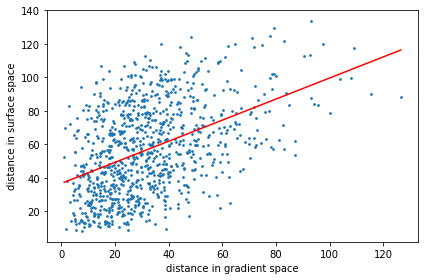

In [2]:
atlas = Atlas('HCP-MMP')
rois = get_rois('MMP-vis3-R')
n_roi = len(rois)
n_item = int((n_roi * n_roi - n_roi) / 2)

# prepare x (梯度空间)
n_pc = 2
pc_maps = nib.load(pjoin(
    anal_dir, 'decomposition/HCPY-M+corrT_MMP-vis3-R_zscore1_PCA-subj.dscalar.nii'
)).get_fdata()[:n_pc]
coords = np.zeros((n_roi, n_pc))
for roi_idx, roi in enumerate(rois):
    mask = atlas.get_mask(roi)[0]
    coords[roi_idx] = np.mean(pc_maps[:, mask], 1)
x = pdist(coords)

# prepare y （surface空间）
gdist_file = pjoin(anal_dir, 'gdist/gdist-between-all-pair-vtx_MMP-vis3-R.pkl')
gdist = pkl.load(open(gdist_file, 'rb'))
vertices = gdist['vtx_number_in_32k_fs_R'].tolist()
reader = CiftiReader(mmp_map_file)
mask = reader.get_data('CIFTI_STRUCTURE_CORTEX_RIGHT', True)[0]
roi2indices = {}
for roi in rois:
    vertices_roi = np.where(mask == atlas.roi2label[roi])[0]
    indices = [vertices.index(vtx) for vtx in vertices_roi]
    roi2indices[roi] = indices
y = np.zeros(n_item)
y_idx = 0
for s_idx, roi1 in enumerate(rois[:-1], 1):
    indices1 = roi2indices[roi1]
    ds1 = gdist['gdist'][indices1]
    for roi2 in rois[s_idx:]:
        indices2 = roi2indices[roi2]
        ds2 = ds1[:, indices2]
        y[y_idx] = np.mean(ds2)
        y_idx += 1

fig, ax = plt.subplots(1, 1)
plot_polyfit(x, y, 1, color='r', s=3, ax=ax)
ax.set_xlabel('distance in gradient space')
ax.set_ylabel('distance in surface space')
fig.tight_layout()
fig.savefig(pjoin(work_dir, 'dist_grad-corr-surface_roi.jpg'))
print('pearsonr', pearsonr(x, y))
print(spearmanr(x, y))

# Development of gradient parameters

## pca_HCPDA_MT_SW_param_local

***early***
===gradient range===
---C1---
polynomial:
  
-0.1799 x + 20.68

score: (0.4897910359236042, 6.168473619351625e-05)


---C2---
polynomial:
  
-0.1785 x + 18.06

score: (0.5769722607033929, 1.1322127427502742e-06)


===gradient variation===
---C1---
polynomial:
  
-0.04857 x + 4.099

score: (0.9233036379642136, 3.3757707216535904e-26)


---C2---
polynomial:
  
-0.01256 x + 2.613

score: (0.5950202268527583, 4.2546587497823324e-07)


===gradient dispersion===
polynomial:
  
-799.1 x + 4.738e+04

score: (0.9377239531646179, 8.896290253886053e-29)


***dorsal***
===gradient range===
---C1---
polynomial:
  
-0.2921 x + 22.89

score: (0.8662910905283541, 1.9511694828163014e-19)


---C2---
polynomial:
  
0.202 x + 13.75

score: (0.6821075660578992, 1.422107154391973e-09)


===gradient variation===
---C1---
polynomial:
  
-0.02068 x + 4.245

score: (0.6778371226428843, 1.967327393574953e-09)


---C2---
polynomial:
  
0.03236 x + 2.188

score: (0.82487886846966, 3.0191960794668934e-1

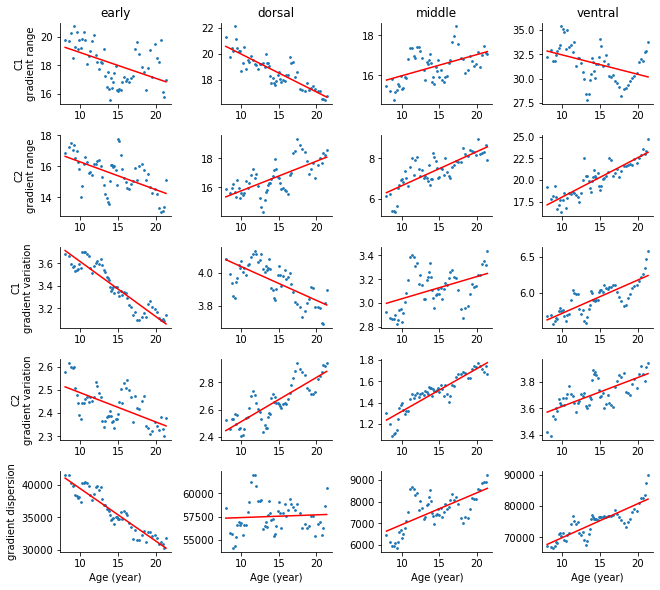

In [6]:
title1 = 'HCPD-M+T_MMP-vis3-R_zscore1_PCA-subj'
title2 = 'SW-width50-step10-merge'
out_file = pjoin(work_dir, f'{title1}_{title2}_param_local-EDMV.jpg')

figsize = (9.3, 8.3)
local_names = ['early', 'dorsal', 'middle', 'ventral']
pc_names = ['C1', 'C2']
param_names = ['gradient range', 'gradient variation', 'gradient dispersion']

fpath = pjoin(anal_dir, f'decomposition/{title1}_{title2}_param_local-EDMV.pkl')
data = pkl.load(open(fpath, 'rb'))
n_pc = len(pc_names)
n_row = n_pc * len(param_names)
n_col = len(local_names)
if 'gradient dispersion' in param_names:
    assert param_names.count('gradient dispersion') == 1
    assert 'gradient dispersion' == param_names[-1]
    n_row = n_row - n_pc + 1
fig, axes = plt.subplots(n_row, n_col, figsize=figsize)
x = data['age in months'] / 12
for local_idx, local_name in enumerate(local_names):
    print(f'***{local_name}***')
    row_idx = 0
    for param_name in param_names:
        print(f'==={param_name}===')
        if param_name == 'gradient dispersion':
            ax = axes[-1, local_idx]
            plot_polyfit(x, data[local_name][param_name], 1, color='r', s=3, ax=ax)
            print('\n')
            ax.set_xlabel('Age (year)')
            if local_idx == 0:
                ax.set_ylabel(param_name)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            continue
        for pc_name in pc_names:
            print(f'---{pc_name}---')
            ax = axes[row_idx, local_idx]
            plot_polyfit(x, data[local_name][f'{pc_name} {param_name}'], 1, color='r', s=3, ax=ax)
            print('\n')
            if row_idx == 0:
                ax.set_title(local_name)
            if local_idx == 0:
                ax.set_ylabel(f'{pc_name}\n{param_name}')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            row_idx += 1

fig.tight_layout()
if out_file is None:
    fig.show()
else:
    fig.savefig(out_file)

## pca_HCPDA_MT_SW_param

===explanation ratio===
---C1---
polynomial:
  
-0.001522 x + 0.4849

score: (0.9610688734535233, 1.3781808289501824e-38)


---C2---
polynomial:
  
0.000178 x + 0.1013

score: (0.4991135569566109, 1.474812545897741e-05)


===gradient range===
---C1---
polynomial:
  
0.0302 x + 38.93

score: (0.3694283748824023, 0.001932755562541319)


---C2---
polynomial:
  
0.1049 x + 20.64

score: (0.8071432438699152, 9.412909022505598e-17)


===gradient variation===
---C1---
polynomial:
  
-0.0116 x + 6.971

score: (0.9377690238509746, 5.020421875047344e-32)


---C2---
polynomial:
  
0.003003 x + 3.167

score: (0.5400344287310994, 2.0053291434313317e-06)


===gradient dispersion===
polynomial:
  
-839.5 x + 3.919e+05

score: (0.8658844383071873, 1.573857523051224e-21)




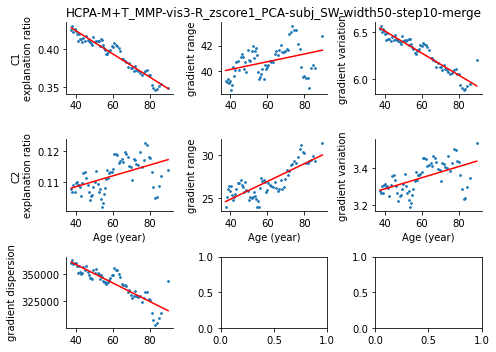

In [8]:
title1 = 'HCPA-M+T_MMP-vis3-R_zscore1_PCA-subj'
title2 = 'SW-width50-step10-merge'
out_file = pjoin(work_dir, f'{title1}_{title2}_param.jpg')

figsize = (7, 5)
pc_names = ['C1', 'C2']
param_names = ['explanation ratio', 'gradient range', 'gradient variation', 'gradient dispersion']

fpath = pjoin(anal_dir, f'decomposition/{title1}_{title2}_param.pkl')
data = pkl.load(open(fpath, 'rb'))
n_row = len(pc_names)
n_col = len(param_names)
if 'gradient dispersion' in param_names:
    assert param_names.count('gradient dispersion') == 1
    assert 'gradient dispersion' == param_names[-1]
    n_row += 1
    n_col -= 1
fig, axes = plt.subplots(n_row, n_col, figsize=figsize)
x = data['age in months'] / 12
for col_idx, param_name in enumerate(param_names):
    print(f'==={param_name}===')
    if param_name == 'gradient dispersion':
        ax = axes[-1, 0]
        plot_polyfit(x, data[param_name], 1, color='r', s=3, ax=ax)
        print('\n')
        ax.set_ylabel(param_name)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        continue
    for row_idx, pc_name in enumerate(pc_names):
        print(f'---{pc_name}---')
        ax = axes[row_idx, col_idx]
        plot_polyfit(x, data[f'{pc_name} {param_name}'], 1, color='r', s=3, ax=ax)
        print('\n')
        if row_idx == 0 and col_idx == int(n_col / 2):
            ax.set_title(f'{title1}_{title2}')
        if row_idx == n_row - 2:
            ax.set_xlabel('Age (year)')
        if col_idx == 0:
            ax.set_ylabel(f'{pc_name}\n{param_name}')
        else:
            ax.set_ylabel(param_name)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

fig.tight_layout()
if out_file is None:
    fig.show()
else:
    fig.savefig(out_file)

## tmp

---C1---
polynomial:
  
-0.001522 x + 0.4849

score: 0.9236533795212242
---C2---
polynomial:
  
0.000178 x + 0.1013

score: 0.24911434273788013


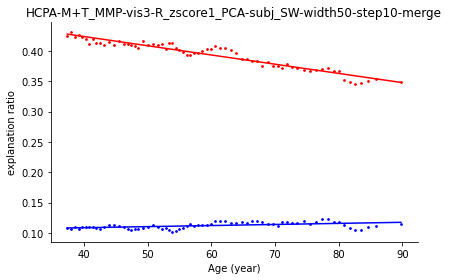

In [3]:
title1 = 'HCPA-M+T_MMP-vis3-R_zscore1_PCA-subj'
title2 = 'SW-width50-step10-merge'
out_file = pjoin(work_dir, f'{title1}_{title2}_param.jpg')

figsize = (6, 4)
pc_names = ['C1', 'C2']
pc2color = {'C1': 'r', 'C2': 'b'}
param_name = 'explanation ratio'

fpath = pjoin(anal_dir, f'decomposition/{title1}_{title2}_param.pkl')
data = pkl.load(open(fpath, 'rb'))
fig, ax = plt.subplots(1, 1, figsize=figsize)
x = data['age in months'] / 12
for row_idx, pc_name in enumerate(pc_names):
    print(f'---{pc_name}---')
    plot_polyfit(x, data[f'{pc_name} {param_name}'], 1, scoring='r2_score',
                 color=pc2color[pc_name], s=3, c=pc2color[pc_name], ax=ax)
ax.set_title(f'{title1}_{title2}')
ax.set_xlabel('Age (year)')
ax.set_ylabel(param_name)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()
fig.savefig(out_file)

# Plot RSM

## RSM8

===early C1===
polynomial:
  
0.006613 x + 0.7569

score: (0.8820602538142684, 6.0650074152084605e-21)


===dorsal C1===
polynomial:
  
0.002445 x + 0.9174

score: (0.8735287375848477, 4.2019668808448813e-20)


===middle C1===
polynomial:
  
0.0009734 x + 0.9579

score: (0.5395577040714302, 7.220525033202574e-06)


===ventral C1===
polynomial:
  
0.002066 x + 0.9336

score: (0.9013524084749547, 4.1309405151403155e-23)


===early C2===
polynomial:
  
0.004744 x + 0.7842

score: (0.7084846366236643, 1.686849410798766e-10)


===dorsal C2===
polynomial:
  
0.008703 x + 0.7663

score: (0.9300643968403932, 2.443573215016009e-27)


===middle C2===
polynomial:
  
0.009916 x + 0.7046

score: (0.7732086681873325, 2.8255624476182153e-13)


===ventral C2===
polynomial:
  
0.004543 x + 0.8092

score: (0.7111622127416923, 1.3408519638368247e-10)




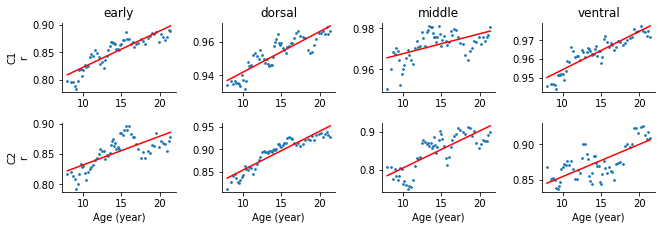

In [3]:
figsize = (9.3, 3.3)
fname = 'RSM8_M+T_MMP-vis3-R_zscore1_PCA-subj_HCPY_corr_HCPD_SW-width50-step10-merge'
pc_names = ['C1', 'C2']
local_names = ['early', 'dorsal', 'middle', 'ventral']
fpath = pjoin(anal_dir, f'RSM/{fname}.pkl')
out_file = pjoin(work_dir, f'{fname}.jpg')

n_pc = len(pc_names)
data = pkl.load(open(fpath, 'rb'))
x = data['age in months'] / 12
fig, axes = plt.subplots(n_pc, len(local_names), figsize=figsize)
for pc_idx, pc_name in enumerate(pc_names):
    for local_idx, local_name in enumerate(local_names):
        print(f'==={local_name} {pc_name}===')
        ax = axes[pc_idx, local_idx]
        row_idx = data['row_name'].index(f'{local_name} {pc_name}')
        plot_polyfit(x, data['r'][row_idx], 1, color='r', s=3, ax=ax)
        print('\n')
        if local_idx == 0:
            ax.set_ylabel(f'{pc_name}\nr')
        if pc_idx == 0:
            ax.set_title(local_name)
        if pc_idx == n_pc - 1:
            ax.set_xlabel('Age (year)')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

fig.tight_layout()
if out_file is None:
    fig.show()
else:
    fig.savefig(out_file)

## RSM7

polynomial:
  
0.001911 x + 0.9456

score: (0.934804161180464, 3.297688366593887e-28)
polynomial:
  
0.008823 x + 0.7492

score: (0.9480472616217478, 4.905460575461416e-31)


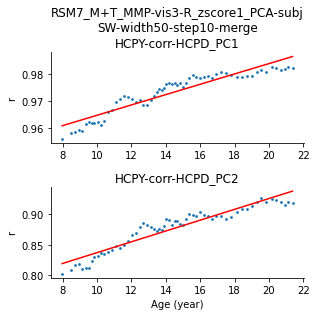

In [4]:
n_win = 61
dataset_name = 'HCPD'

# n_win = 68
# dataset_name = 'HCPA'

figsize=(4.5, 4.5)
pc_names = ['C1', 'C2']
title1 = 'RSM7_M+T_MMP-vis3-R_zscore1_PCA-subj'
title3 = 'SW-width50-step10-merge'

n_pc = len(pc_names)
fpath = pjoin(anal_dir, f'RSM/{title1}_HCPY_corr_{dataset_name}_{title3}.pkl')
out_file = pjoin(work_dir, f"RSM7_{dataset_name}.jpg")
data = pkl.load(open(fpath, 'rb'))
fig, axes = plt.subplots(n_pc, 1, figsize=figsize)
x = data['age in months'] / 12
for pc_idx, pc_name in enumerate(pc_names):
    title2 = f'HCPY-corr-{dataset_name}_P{pc_name}'
    cols = [f'HCPY-{pc_name}_corr_Win{i}' for i in range(1, n_win + 1)]
    row_idx = row_indices = data['row_name'].index(pc_name)
    col_indices = [data['col_name'].index(i) for i in cols]
    ax = axes[pc_idx]
    y = data['r'][row_idx][col_indices]
    plot_polyfit(x, y, 1, color='r', s=3, ax=ax)
    if pc_idx == 0:
        ax.set_title(f'{title1}\n{title3}\n{title2}')
    else:
        ax.set_title(title2)
    if pc_idx == n_pc - 1:
        ax.set_xlabel('Age (year)')
    ax.set_ylabel('r')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.tight_layout()
if out_file is None:
    fig.show()
else:
    fig.savefig(out_file)


## tmp

polynomial:
  
0.001911 x + 0.9456

score: 0.8738588197603111
polynomial:
  
0.008823 x + 0.7492

score: 0.8987936102684947


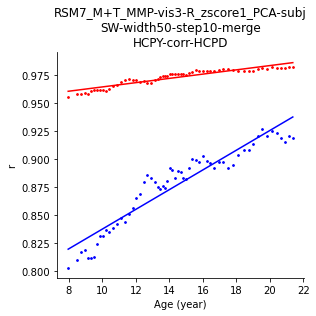

In [5]:
n_win = 61
dataset_name = 'HCPD'

# n_win = 68
# dataset_name = 'HCPA'

figsize=(4.5, 4.5)
pc_names = ['C1', 'C2']
pc2color = {'C1': 'r', 'C2': 'b'}
title1 = 'RSM7_M+T_MMP-vis3-R_zscore1_PCA-subj'
title2 = f'HCPY-corr-{dataset_name}'
title3 = 'SW-width50-step10-merge'

fpath = pjoin(anal_dir, f'RSM/{title1}_HCPY_corr_{dataset_name}_{title3}.pkl')
out_file = pjoin(work_dir, f"RSM7_{dataset_name}.jpg")
data = pkl.load(open(fpath, 'rb'))
fig, ax = plt.subplots(1, 1, figsize=figsize)
x = data['age in months'] / 12
for pc_idx, pc_name in enumerate(pc_names):
    cols = [f'HCPY-{pc_name}_corr_Win{i}' for i in range(1, n_win + 1)]
    row_idx = data['row_name'].index(pc_name)
    col_indices = [data['col_name'].index(i) for i in cols]
    y = data['r'][row_idx][col_indices]
    plot_polyfit(x, y, 1, color=pc2color[pc_name], s=3,
                 scoring='r2_score', c=pc2color[pc_name], ax=ax)

ax.set_title(f'{title1}\n{title3}\n{title2}')
ax.set_xlabel('Age (year)')
ax.set_ylabel('r')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()
fig.savefig(out_file)


# Plot Fit

## HCPDA_MT_fit_PC12_SW

polynomial:
  
-0.0004697 x + 0.9952

score: (0.8999658583614474, 1.731068271811442e-25)
polynomial:
  
-0.001703 x + 0.9847

score: (0.9045461022138921, 3.971865652938619e-26)


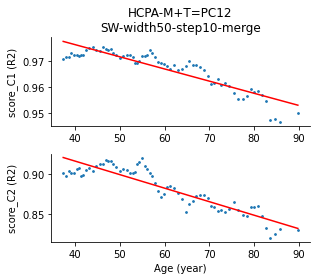

In [4]:
fname1 = 'HCPA-M+T=PC12'
fname2 = 'SW-width50-step10-merge'
figsize = (4.5, 4)
out_file = pjoin(work_dir, f'{fname1}_{fname2}_score.jpg')

# out_file = None

fpath = pjoin(anal_dir, f'fit/{fname1}_{fname2}.pkl')
data = pkl.load(open(fpath, 'rb'))
pc_names = ['C1', 'C2']
n_pc = len(pc_names)
x = data['age in months'] / 12
fig, axes = plt.subplots(n_pc, 1, figsize=figsize)
for pc_idx, pc_name in enumerate(pc_names):
    ax = axes[pc_idx]
    y = data[f'score_{pc_name}']
    plot_polyfit(x, y, 1, color='r', s=3, ax=ax)
    if pc_idx == 0:
        ax.set_title(f'{fname1}\n{fname2}')
    if pc_idx == n_pc - 1:
        ax.set_xlabel('Age (year)')
    ax.set_ylabel(f'score_{pc_name} (R2)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.tight_layout()
if out_file is None:
    fig.show()
else:
    fig.savefig(out_file)

# 结构PC1/2与其它指标在顶点级别上的相关

## 在整个视觉皮层上的相关

pixdim[1,2,3] should be non-zero; setting 0 dims to 1



---PC1---
polynomial:
  
5.25 x - 27.21

score: (0.558605513950005, 2.979512441492283e-211)
spearmanr: SpearmanrResult(correlation=0.5306825187157226, pvalue=4.656650722872057e-187)
pearsonr: (0.558605513950005, 2.979512441492283e-211)

---PC2---
polynomial:
  
-0.6701 x - 0.5792

score: (0.15899594324229963, 4.821079519237994e-16)
spearmanr: SpearmanrResult(correlation=0.10559684947088743, pvalue=7.835558824862867e-08)
pearsonr: (-0.15899594324229965, 4.821079519237994e-16)


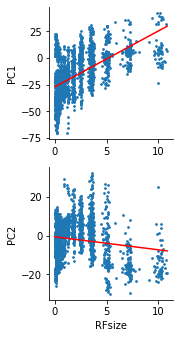

In [4]:
# mask_type = 'MMP-vis3'
# mask_type = 'R2_limit'
mask_type = 'Wang2015'

Hemi = 'L'
meas_name = 'RFsize'
figsize = (2.6, 4.8)
n_pc = 2
pc_names = [f'PC{i}' for i in range(1, n_pc + 1)]
meas2file = {
    'ECC': s1200_avg_eccentricity,
    'RFsize': s1200_avg_RFsize}
out_file = pjoin(work_dir, f'PC12-corr-{meas_name}-{Hemi}.jpg')
# out_file = 'show'

mask = Atlas('HCP-MMP').get_mask(get_rois(f'MMP-vis3-{Hemi}'))[0]
if mask_type in 'MMP-vis3':
    pass
elif mask_type == 'R2_limit':
    mask_tmp = nib.load(s1200_avg_R2).get_fdata()[0, :LR_count_32k] > 9.8
    mask = np.logical_and(mask, mask_tmp)
elif mask_type == 'Wang2015':
    # R_FEF和R_IPS5与MMP-vis3-R没有重合的部分，前者在额叶，后者本身只有3个顶点。
    mask_tmp = Atlas('Wang2015').get_mask(get_rois(f'Wang2015-{Hemi}'))[0]
    mask = np.logical_and(mask, mask_tmp)
else:
    raise ValueError('unsupported mask_type:', mask_type)

map_pcs = nib.load(pjoin(
    anal_dir, f'decomposition/HCPY-M+corrT_MMP-vis3-{Hemi}_zscore1_PCA-subj.dscalar.nii'
)).get_fdata()[:n_pc, mask]
map_meas = nib.load(meas2file[meas_name]).get_fdata()[0, :LR_count_32k]
map_meas = map_meas[mask]

fig, axes = plt.subplots(n_pc, 1, figsize=figsize)
for pc_idx, pc_name in enumerate(pc_names):
    ax = axes[pc_idx]
    print(f'\n---{pc_name}---')
    plot_polyfit(map_meas, map_pcs[pc_idx], 1, color='r', s=3, ax=ax)
    print('spearmanr:', spearmanr(map_meas, map_pcs[pc_idx]))
    print('pearsonr:', pearsonr(map_meas, map_pcs[pc_idx]))
    ax.set_ylabel(pc_name)
    if pc_idx == (n_pc - 1):
        ax.set_xlabel(meas_name)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

## 用(Benson et al., 2018, eLife)中的retinotopic prior来做相关

---1.5xIQR borders---
[-4.8561011254787445, 10.176775604486465]

---2xIQR borders---
[-6.735210716724396, 12.055885195732117]

---3xIQR borders---
[-10.493429899215698, 15.81410437822342]


---stru-C1---
polynomial:
  
0.0589 x - 22.24

score: (0.018530671840515614, 0.017736203900284343)
spearmanr: SpearmanrResult(correlation=-0.09337175126870702, pvalue=4.95401433822832e-33)
pearsonr: (0.018530671840515635, 0.017736203900284343)

---stru-C2---
polynomial:
  
0.3529 x + 1.637

score: (0.196788311232393, 1.2761029519153884e-142)
spearmanr: SpearmanrResult(correlation=0.31972961366743274, pvalue=0.0)
pearsonr: (0.196788311232393, 1.2761029519153884e-142)


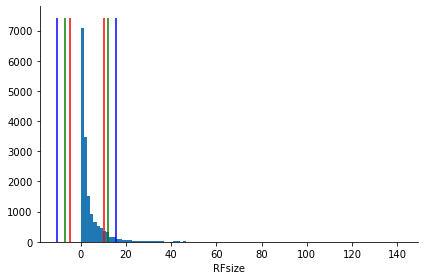

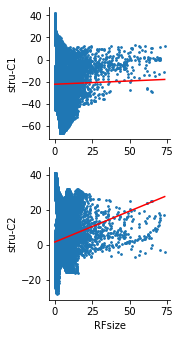

In [2]:
remove_outlier = 18.75
iqr_coefs = (1.5, 2, 3)
iqr_colors = ('r', 'g', 'b')

meas_name = 'RFsize'
figsize = (2.6, 4.8)
n_pc = 2
pc_names = [f'stru-C{i}' for i in range(1, n_pc + 1)]
gii_pcs = nib.load(pjoin(
    anal_dir, 'decomposition/HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_fsavg.func.gii'
))
meas2file = {
    'ECC': pjoin(proj_dir, 'data/benson2018/analyses/fsaverage/rh.anatomical-prior_eccen.mgz'),
    'RFsize': pjoin(proj_dir, 'data/benson2018/analyses/fsaverage/rh.anatomical-prior_sigma.mgz')}
atlas_file = pjoin(proj_dir, 'data/benson2018/analyses/fsaverage/rh.anatomical-prior_varea.mgz')
out_file = pjoin(work_dir, f'PC12-corr-{meas_name}.jpg')
# out_file = 'show'

mask_meas = nib.load(atlas_file).get_fdata().squeeze() != 0
map_pcs = [gii_pcs.darrays[i].data for i in range(n_pc)]
map_meas = nib.load(meas2file[meas_name]).get_fdata().squeeze()
mask_pc = ~np.isnan(map_pcs[0])
assert np.all(mask_pc == ~np.isnan(map_pcs[1]))
mask = np.logical_and(mask_meas, mask_pc)
map_pcs = [i[mask] for i in map_pcs]
map_meas = map_meas[mask]


fig_, ax_ = plt.subplots()
ax_.hist(map_meas, bins=100, orientation='vertical')
ymin, ymax = ax_.get_ylim()
Q1 = np.percentile(map_meas, 25)
Q3 = np.percentile(map_meas, 75)
IQR = Q3 - Q1
for i, iqr_coef in enumerate(iqr_coefs):
    step = iqr_coef * IQR
    whiskers = [Q1-step, Q3+step]
    print(f'---{iqr_coef}xIQR borders---')
    print(whiskers, end='\n\n')
    ax_.vlines(whiskers, ymin, ymax, colors=iqr_colors[i])
    ax_.set_xlabel(meas_name)
    ax_.spines['top'].set_visible(False)
    ax_.spines['right'].set_visible(False)
fig_.tight_layout()
fig_.show()

if remove_outlier is not None:
    step = remove_outlier * IQR
    mask_iqr = np.logical_and(map_meas <= Q3+step, map_meas >= Q1-step)
    map_pcs = [i[mask_iqr] for i in map_pcs]
    map_meas = map_meas[mask_iqr]

fig, axes = plt.subplots(n_pc, 1, figsize=figsize)
for pc_idx, pc_name in enumerate(pc_names):
    ax = axes[pc_idx]
    print(f'\n---{pc_name}---')
    plot_polyfit(map_meas, map_pcs[pc_idx], 1, color='r', s=3, ax=ax)
    print('spearmanr:', spearmanr(map_meas, map_pcs[pc_idx]))
    print('pearsonr:', pearsonr(map_meas, map_pcs[pc_idx]))
    ax.set_ylabel(pc_name)
    if pc_idx == (n_pc - 1):
        ax.set_xlabel(meas_name)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

## 在早期的那几个视觉区域中，画PC1/2和eccentricity之间的散点图

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


polynomial:
  
-0.2189 x - 3.634

score: (0.6028927503274788, 4.671817153322881e-79)
polynomial:
  
0.1195 x + 6.463

score: (0.3309881202388443, 1.4168461118338246e-21)
polynomial:
  
-0.07216 x + 5.29

score: (0.09047934271342539, 0.02580379641537228)
polynomial:
  
0.1411 x + 8.064

score: (0.40963580035426195, 5.803016205023234e-26)
polynomial:
  
0.3843 x + 13.99

score: (0.5629132976314455, 2.5961678980127633e-31)
polynomial:
  
-0.1395 x + 5.309

score: (0.2146652247295677, 4.216358225640636e-05)
polynomial:
  
-0.02307 x + 2.653

score: (0.08159632306044795, 0.16144380185187454)
polynomial:
  
0.2369 x + 1.824

score: (0.32495282865266695, 1.0459364554396725e-08)
polynomial:
  
0.03832 x + 7.841

score: (0.4041047719197398, 3.8572733219901374e-07)
polynomial:
  
-0.04778 x + 6.911

score: (0.27682974398690036, 0.0006880065768553137)


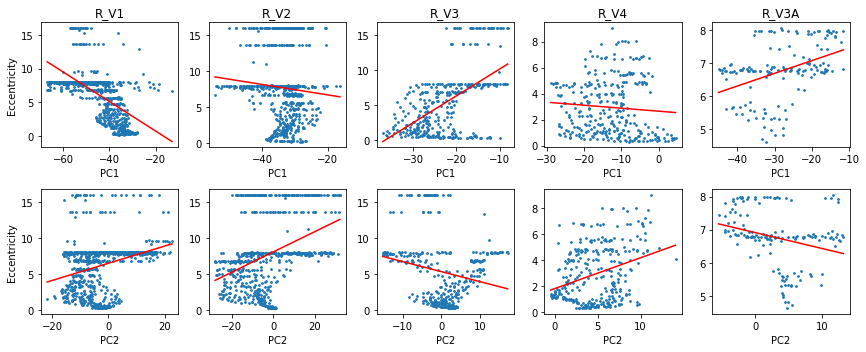

In [8]:
figsize = (12, 5)
n_pc = 2
pc_names = [f'PC{i}' for i in range(1, n_pc + 1)]
rois = ['R_V1', 'R_V2', 'R_V3', 'R_V4', 'R_V3A']
n_roi = len(rois)
out_file = pjoin(work_dir, 'PC12-corr-ECC_area.jpg')
# out_file = None

map_pcs = nib.load(pjoin(
    anal_dir, 'decomposition/HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj.dscalar.nii'
)).get_fdata()[:n_pc]
map_ecc = nib.load(s1200_avg_eccentricity).get_fdata()[0, :LR_count_32k]
atlas = Atlas('HCP-MMP')

fig, axes = plt.subplots(n_pc, n_roi, figsize=figsize)
for roi_idx, roi in enumerate(rois):
    mask = atlas.get_mask(roi)[0]
    for pc_idx, pc_name in enumerate(pc_names):
        ax = axes[pc_idx, roi_idx]
        roi_pc = map_pcs[pc_idx, mask]
        roi_ecc = map_ecc[mask]
        plot_polyfit(roi_pc, roi_ecc, 1, color='r', s=3, ax=ax)
        ax.set_xlabel(pc_name)
        if roi_idx == 0:
            ax.set_ylabel('Eccentricity')
        if pc_idx == 0:
            ax.set_title(roi)
fig.tight_layout()
if out_file is None:
    fig.show()
else:
    fig.savefig(out_file)

# 用PC1和PC2分别作为横轴和纵轴，用分区颜色给每个点上色

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


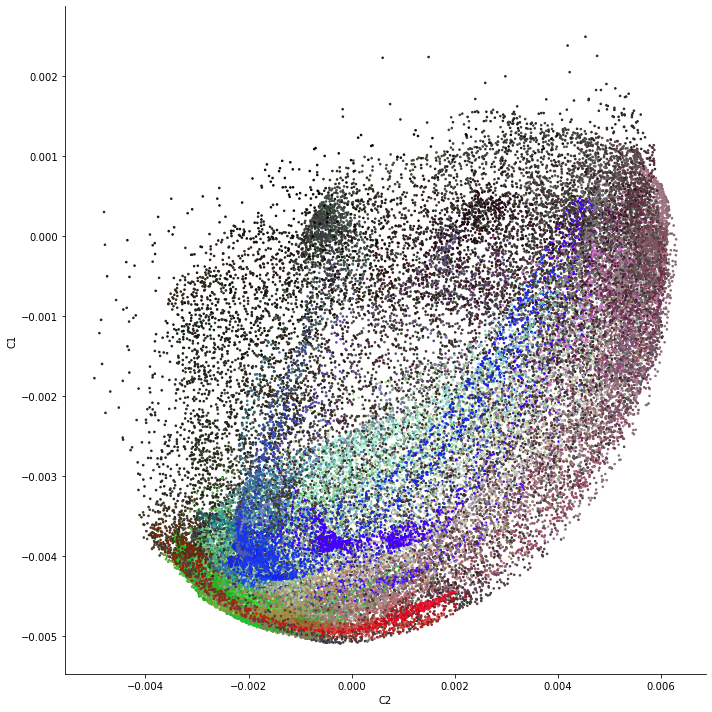

In [3]:
figsize = (10, 10)

# mask = Atlas('HCP-MMP').get_mask('LR', 'grayordinate')[0]
# pc_file = pjoin(anal_dir, 'decomposition/S1200-grp-RSFC-r_grayordinate2grayordinate_zscore_PCA-comp.dscalar.nii')

# mask = Atlas('HCP-MMP').get_mask('LR')[0]
# pc_file = pjoin(anal_dir, 'decomposition/RSFC_MMP-vis3-R2cortex_PCA-weight.dscalar.nii')

mask = Atlas('HCP-MMP').get_mask('LR', 'grayordinate')[0]
pc_file = pjoin(anal_dir, 'decomposition/HCPY-avg_RSFC-MMP-vis3-R2grayordinate_zscore_PCA-weight.dscalar.nii')

# target
trg_reader = CiftiReader(mmp_map_file)
out_file = pjoin(work_dir, 'PC1+2_predict_MMP.jpg')
# out_file = 'show'

pc_maps = nib.load(pc_file).get_fdata()[:2, mask]
trg_map = trg_reader.get_data()[0]
lbl_tab = trg_reader.label_tables()[0]
colors = [lbl_tab[i].rgba for i in trg_map]
colors = np.array(colors)

fig, ax = plt.subplots(figsize=figsize)
ax.scatter(pc_maps[1], pc_maps[0], c=colors, s=2.5)
ax.set_xlabel('C2')
ax.set_ylabel('C1')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

# 用stru-C1, gdistFromCS为轴，画出V1~4和MT，POS1的位置

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


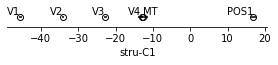

In [12]:
figsize = (4, 1)
data_flag = 'stru-C1'
if data_flag == 'stru-C1':
    fpath = pjoin(anal_dir, 'decomposition/HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj.dscalar.nii')
    rois_flag = ['MT']
elif data_flag == 'gdistFromCS':
    fpath = pjoin(anal_dir, 'gdist/gdist_src-CalcarineSulcus.dscalar.nii')
    rois_flag = ['POS1', 'V3']
else:
    raise ValueError('not supported data_flag:', data_flag)
out_file = pjoin(work_dir, f'hierarchy-position-{data_flag}.jpg')

rois = ['R_V1', 'R_V2', 'R_V3', 'R_V4', 'R_MT', 'R_POS1']
atlas = Atlas('HCP-MMP')
n_roi = len(rois)
feat_map = nib.load(fpath).get_fdata()[0]

fig, ax = plt.subplots(figsize=figsize)
y = np.ones(n_roi)
x = np.zeros(n_roi)
x_err = np.zeros(n_roi)
for roi_idx, roi in enumerate(rois):
    mask = atlas.get_mask(roi)[0]
    feat_values = feat_map[mask]
    x[roi_idx] = np.mean(feat_values)
    x_err[roi_idx] = sem(feat_values)
ax.errorbar(x, y, xerr=x_err, ecolor='k', linestyle='',
            marker='o', mfc=(1, 1, 1, 0), mec='k')
for j, i, roi in zip(x, y, rois):
    roi = roi.lstrip('R_')
    if roi in rois_flag:
        ha, va = 'left', 'bottom'
    else:
        ha, va = 'right', 'bottom'
    ax.text(j, i, roi, horizontalalignment=ha, verticalalignment=va)
ax.set_xlabel(data_flag)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(left=False, labelleft=False)
fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)